# Group No: 18

## Group Members Names:

 1. PEYALA SAMARASIMHA REDDY - 2023AA05072
 2. PEGALLAPATI SAI MAHARSHI - 2023AA05924
 3. ANIRUDDHA DILIP MADURWAR - 2023AA05982
 4. TUSHAR DEEP - 2023AA05885

# Part 2: Practical Implementation

# Tasks

# Task 1. **Vertical Partitioning (30 Points)**  
   - Split the original model into two sub-models:
     - **Model A**: Processes features related to the network (e.g., Signal Strength, Network Traffic).
     - **Model B**: Processes features related to user behavior (e.g., User Count, Device Type).
   - Combine the outputs of Model A and Model B to predict network latency.
   - Compare the performance of the partitioned model to the original monolithic model using metrics like accuracy and latency prediction error.


## Dataset:
We have taken a sample synthetic dataset with 1000 rows for these tasks belongs to the telecommunication domain and we are using same dataset for these tasks.

## 1. Load and Explore the Dataset


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

# Load the dataset
file_path = "network_latency_dataset.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values and data types
print("\nDataset Info:")
print(df.info())

# Checking for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

print("")
# Visualizing Latency distribution
plt.figure(figsize=(6, 3))
sns.histplot(df["Latency"], bins=30, kde=True, color='blue')
plt.title("Latency Distribution")
plt.xlabel("Latency (ms)")
plt.ylabel("Frequency")
plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [26]:
# Print the data
print("\nSanity Check of the dataset:")
print(df)



Sanity Check of the dataset:
     Tower_ID  Signal_Strength  Network_Traffic     Latency  User_Count  \
0           1       -81.272994       193.281600   59.724080         883   
1           2       -52.464285       546.481938   56.925972         313   
2           3       -63.400303       874.216378  182.188370         997   
3           4       -70.067076       734.902638   57.413778         840   
4           5       -92.199068       808.495536   61.670448         519   
..        ...              ...              ...         ...         ...   
995       996       -95.420896       660.385605  174.406194         207   
996       997       -54.134321       957.048475   39.881910         607   
997       998       -93.159068        78.268436   68.859693         885   
998       999       -52.488132        66.484174   65.108651         734   
999      1000       -77.699711       289.365204  175.568666         366   

     Device_Type Geographic_Category  
0              0              

##  2: Preprocessing and Feature Scaling

In [2]:
# Encoding categorical features (One-Hot Encoding)
df = pd.get_dummies(df, columns=["Device_Type", "Geographic_Category"], drop_first=True)
print("\nDataset after One-Hot Encoding:")
print(df.head())

# Define feature categories
network_features = ["Signal_Strength", "Network_Traffic"]
user_features = ["User_Count"] + [col for col in df.columns if "Device_Type_" in col]  # Encoded device types

# Define input (X) and target (y)
X = df.drop(columns=["Tower_ID", "Latency"])  # Features
y = df["Latency"]  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

print("\nFeature shape after scaling:", X_train_scaled_df.shape)

# Extract network and user-related feature sets
X_train_network = X_train_scaled_df[network_features].values
X_train_user = X_train_scaled_df[user_features].values
X_test_network = X_test_scaled_df[network_features].values
X_test_user = X_test_scaled_df[user_features].values

print("\nNetwork Features Shape:", X_train_network.shape)
print("\nUser Features Shape:", X_train_user.shape)



Dataset after One-Hot Encoding:
   Tower_ID  Signal_Strength  Network_Traffic     Latency  User_Count  \
0         1       -81.272994       193.281600   59.724080         883   
1         2       -52.464285       546.481938   56.925972         313   
2         3       -63.400303       874.216378  182.188370         997   
3         4       -70.067076       734.902638   57.413778         840   
4         5       -92.199068       808.495536   61.670448         519   

   Device_Type_1  Device_Type_2  Device_Type_3  Geographic_Category_Urban  
0          False          False          False                      False  
1          False          False          False                      False  
2           True          False          False                       True  
3          False           True          False                       True  
4           True          False          False                       True  

Feature shape after scaling: (800, 7)

Network Features Shape: (800, 2)

## 3. Define and Create Models for Vertical Partitioning

In [3]:
# Define Model A (Network-related features)
def create_model_a(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(16, activation='relu')(x)  # Intermediate representation
    return Model(inputs, outputs)

# Define Model B (User-related features)
def create_model_b(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(16, activation='relu')(x)  # Intermediate representation
    return Model(inputs, outputs)

# Create Model A & B
model_a = create_model_a(X_train_network.shape[1])
model_b = create_model_b(X_train_user.shape[1])

# Display model architectures
print("Model A Summary:")
model_a.summary()
print("\nModel B Summary:")
model_b.summary()

# Merge Model Outputs
combined_input = Concatenate()([model_a.output, model_b.output])
x = Dense(32, activation='relu')(combined_input)
x = Dense(16, activation='relu')(x)
final_output = Dense(1, activation='linear')(x)

# Define Final Combined Model
final_model = Model(inputs=[model_a.input, model_b.input], outputs=final_output)
final_model.compile(optimizer="adam", loss="mse", metrics=["mae"])


Model A Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,800 (10.94 KB)

 Trainable params: 2,800 (10.94 KB)

 Non-trainable params: 0 (0.00 B)


Model B Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,928 (11.44 KB)

 Trainable params: 2,928 (11.44 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the Vertical Partitioning Model

In [5]:
# Train the combined model
history = final_model.fit(
    [X_train_network, X_train_user], y_train,
    epochs=100, batch_size=32,
    validation_data=([X_test_network, X_test_user], y_test),
    verbose=1
)



Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2977.4504 - mae: 46.5806 - val_loss: 3179.7224 - val_mae: 48.1171
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2976.9888 - mae: 46.7910 - val_loss: 3156.0120 - val_mae: 48.0550
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3168.3003 - mae: 48.8828 - val_loss: 3186.3047 - val_mae: 48.0854
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3080.1306 - mae: 47.4572 - val_loss: 3168.6272 - val_mae: 48.1134
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2924.8955 - mae: 46.3243 - val_loss: 3226.0830 - val_mae: 48.4074
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2892.0242 - mae: 45.9360 - val_loss: 3178.9028 - val_mae: 48.1647
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3145.3733 - mae: 48.2915 - val_loss: 3189.4233 - val_mae: 48.2343
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3101.5234 - mae: 48.1963 - val_loss: 3185.4287 - val_mae: 48.2403


## 5. Evaluate the Partitioned model

In [6]:
# Make predictions with the combined model
y_pred_combined = final_model.predict([X_test_network, X_test_user])

# Calculate R2 Score and MAE for the combined model
r2_combined = r2_score(y_test, y_pred_combined)
mae_combined = mean_absolute_error(y_test, y_pred_combined)

print(f"\nPartitioned Model Performance:")
print(f"R2 Score: {r2_combined:.4f}")
print(f"MAE: {mae_combined:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Partitioned Model Performance:
R2 Score: -0.0205
MAE: 48.7620


## 6. Create the Monolithic Model

In [7]:
# Build a Monolithic Model for Comparison
input_layer = Input(shape=(X_train_scaled.shape[1],))
x = Dense(128, activation="relu")(input_layer)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
output_layer = Dense(1, activation="linear")(x)

monolithic_model = Model(inputs=input_layer, outputs=output_layer)
monolithic_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Print the summary of the model
monolithic_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 7)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,393 (44.50 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Train the Monolithic Model

In [8]:
history_mono = monolithic_model.fit(
    X_train_scaled, y_train,
    epochs=100, batch_size=32,
    validation_data=(X_test_scaled, y_test),
    verbose=1
)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 13889.3682 - mae: 104.2940 - val_loss: 12801.6055 - val_mae: 98.3539
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13803.4082 - mae: 103.9873 - val_loss: 10040.2998 - val_mae: 83.8402
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9039.1338 - mae: 79.6328 - val_loss: 4200.2988 - val_mae: 54.0624
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3812.7937 - mae: 51.4164 - val_loss: 3559.6248 - val_mae: 50.4830
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3179.4617 - mae: 48.1345 - val_loss: 3286.8035 - val_mae: 48.7565
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3090.8020 - mae: 47.7671 - val_loss: 3291.0078 - val_mae: 48.8913
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3016.2671 - mae: 47.3197 - val_loss: 3279.3838 - val_mae: 48.8585
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2971.7881 - mae: 46.7029 - val_loss: 3307.0093 - val_mae: 4

## 7. Evaluate the Monolithic Model

In [9]:
# Make predictions with the monolithic model
y_pred_mono = monolithic_model.predict(X_test_scaled)

# Calculate R2 score and MAE for the monolithic model
r2_mono = r2_score(y_test, y_pred_mono)
mae_mono = mean_absolute_error(y_test, y_pred_mono)

print(f"\nMonolithic Model Performance:")
print(f"R2 Score: {r2_mono:.4f}")
print(f"MAE: {mae_mono:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Monolithic Model Performance:
R2 Score: -0.1159
MAE: 50.9698


## 8. Model Comparison

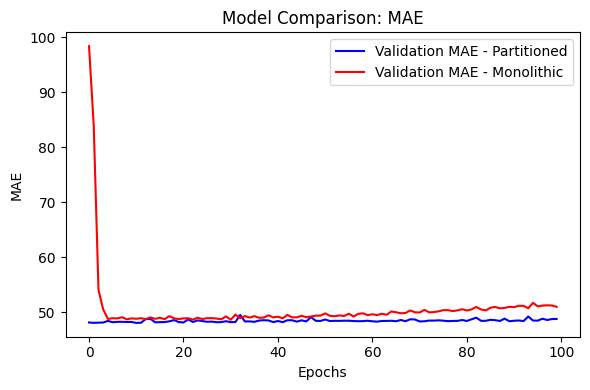

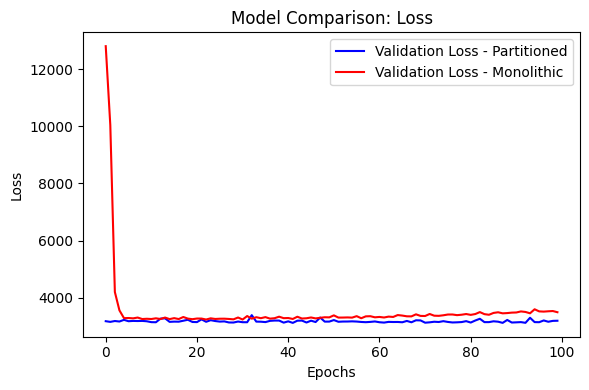

In [14]:
# Plot Training and Validation R² for the models
plt.figure(figsize=(6, 4))
plt.plot(history.history['val_mae'], label="Validation MAE - Partitioned", color='blue')
plt.plot(history_mono.history['val_mae'], label="Validation MAE - Monolithic", color='red')
plt.title("Model Comparison: MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.tight_layout()
plt.show()

print('\n')
# Plot Training and Validation R² for the models
plt.figure(figsize=(6, 4))
plt.plot(history.history['val_loss'], label="Validation Loss - Partitioned", color='blue')
plt.plot(history_mono.history['val_loss'], label="Validation Loss - Monolithic", color='red')
plt.title("Model Comparison: Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# Compare Models
print("\nModel Performance Comparison:")
print(f"🔹 Partitioned Model - R2 Score: {r2_combined:.4f}, MAE: {mae_combined:.4f}")
print(f"🔹 Monolithic Model - R2 Score: {r2_mono:.4f}, MAE: {mae_mono:.4f}")


Model Performance Comparison:
🔹 Partitioned Model - R2 Score: -0.0205, MAE: 48.7620
🔹 Monolithic Model - R2 Score: -0.1159, MAE: 50.9698


### Model Performance Comparison

**Partitioned Model**:
- **R² Score**: -0.0205
- **MAE**: 48.7620

**Monolithic Model**:
- **R² Score**: -0.1159
- **MAE**: 50.9698

### Analysis:

- **R² Score**: The R² score represents the proportion of variance in the target variable (latency) explained by the model. Both models have negative R² values, indicating that they are not performing very well in explaining the variance of the target variable. However, the **partitioned model** performs better with a higher R² score (-0.0205) compared to the monolithic model (-0.1159). This suggests that the partitioned model is slightly more effective at explaining the variance in the target.

- **MAE (Mean Absolute Error)**: The MAE represents the average absolute error between the model's predictions and the actual values. A lower MAE indicates better model performance. Here, the **partitioned model** also outperforms the monolithic model with a lower MAE of 48.7620, compared to the monolithic model's MAE of 50.9698. This indicates that the partitioned model is slightly more accurate in predicting latency.

### Overall Conclusion:
In this case, the **partitioned model** outperforms the **monolithic model** in terms of both R² score and MAE, suggesting that splitting the features into two separate models (network and user-related) leads to better performance in predicting network latency.


# Task 2. **Horizontal Partitioning (30 Points)**
  - Divide the dataset into two subsets based on geographic categories:
    - Subset 1: Urban cell towers.
    - Subset 2: Rural cell towers.
  - Train separate models for each subset and compare their performance to a single model trained on the entire dataset.
  - Provide insights into the benefits of horizontal partitioning in this scenario.


## 1. Load and Prepare the Data


First 5 rows of the dataset:
   Tower_ID  Signal_Strength  Network_Traffic     Latency  User_Count  \
0         1       -81.272994       193.281600   59.724080         883   
1         2       -52.464285       546.481938   56.925972         313   
2         3       -63.400303       874.216378  182.188370         997   
3         4       -70.067076       734.902638   57.413778         840   
4         5       -92.199068       808.495536   61.670448         519   

   Device_Type Geographic_Category  
0            0               Rural  
1            0               Rural  
2            1               Urban  
3            2               Urban  
4            1               Urban  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Tower_ID             1000 non-null   int64  
 1   Signal_Strength      1000 non-null

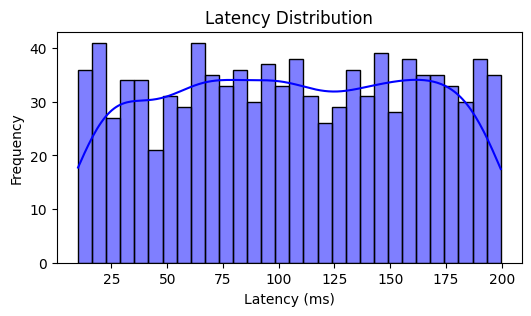

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

# Load the dataset
file_path = "network_latency_dataset.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for missing values and data types
print("\nDataset Info:")
print(df.info())

# Checking for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

print("")
# Visualizing Latency distribution
plt.figure(figsize=(6, 3))
sns.histplot(df["Latency"], bins=30, kde=True, color='blue')
plt.title("Latency Distribution")
plt.xlabel("Latency (ms)")
plt.ylabel("Frequency")
plt.show()


In [46]:
# Print the data
print("\nSanity Check of the dataset:")
print(df)



Sanity Check of the dataset:
     Tower_ID  Signal_Strength  Network_Traffic     Latency  User_Count  \
0           1       -81.272994       193.281600   59.724080         883   
1           2       -52.464285       546.481938   56.925972         313   
2           3       -63.400303       874.216378  182.188370         997   
3           4       -70.067076       734.902638   57.413778         840   
4           5       -92.199068       808.495536   61.670448         519   
..        ...              ...              ...         ...         ...   
995       996       -95.420896       660.385605  174.406194         207   
996       997       -54.134321       957.048475   39.881910         607   
997       998       -93.159068        78.268436   68.859693         885   
998       999       -52.488132        66.484174   65.108651         734   
999      1000       -77.699711       289.365204  175.568666         366   

     Device_Type Geographic_Category  
0              0              

##  2: Preprocessing and Feature Scaling

In [47]:
# Ensure 'Geographic_Category_Urban' is included in features before splitting
df = pd.get_dummies(df, columns=["Geographic_Category"], drop_first=False)

# Define input (X) and target (y)
X = df.drop(columns=["Tower_ID", "Latency"])  # Feature set
y = df["Latency"]  # Target variable

# Split into Train and Test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrame (to keep column names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

## 3. Partition Data Based on Geographic Categories

In [48]:

# Split into Urban and Rural using X_train_scaled (instead of df)
X_train_urban = X_train_scaled[X_train["Geographic_Category_Urban"] == 1].drop(columns=["Geographic_Category_Urban"])
y_train_urban = y_train[X_train["Geographic_Category_Urban"] == 1]

X_train_rural = X_train_scaled[X_train["Geographic_Category_Urban"] == 0].drop(columns=["Geographic_Category_Urban"])
y_train_rural = y_train[X_train["Geographic_Category_Urban"] == 0]

# Do the same for test data
X_test_urban = X_test_scaled[X_test["Geographic_Category_Urban"] == 1].drop(columns=["Geographic_Category_Urban"])
y_test_urban = y_test[X_test["Geographic_Category_Urban"] == 1]

X_test_rural = X_test_scaled[X_test["Geographic_Category_Urban"] == 0].drop(columns=["Geographic_Category_Urban"])
y_test_rural = y_test[X_test["Geographic_Category_Urban"] == 0]

# 🔹 Print the shapes after splitting
print("\nFinal Shapes After Fix:")
print(f"X_train_urban: {X_train_urban.shape}, y_train_urban: {y_train_urban.shape}")
print(f"X_train_rural: {X_train_rural.shape}, y_train_rural: {y_train_rural.shape}")
print(f"X_test_urban: {X_test_urban.shape}, y_test_urban: {y_test_urban.shape}")
print(f"X_test_rural: {X_test_rural.shape}, y_test_rural: {y_test_rural.shape}")



Final Shapes After Fix:
X_train_urban: (397, 5), y_train_urban: (397,)
X_train_rural: (403, 5), y_train_rural: (403,)
X_test_urban: (102, 5), y_test_urban: (102,)
X_test_rural: (98, 5), y_test_rural: (98,)


## 4. Define Model Function

In [59]:
def create_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dense(32, activation='relu')(x)
    # Modify the output layer to have 1 unit and a linear activation for regression
    outputs = Dense(1, activation='linear')(x)  # Output a single scalar value for regression
    return Model(inputs, outputs)

# Create models for Urban and Rural
urban_model = create_model(X_train_urban.shape[1])  # Input shape for Urban data
rural_model = create_model(X_train_rural.shape[1])  # Input shape for Rural data

# Compile the models
urban_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
rural_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Print the model summaries
print("Urban Model Summary:")
urban_model.summary()

print("\nRural Model Summary:")
rural_model.summary()


Urban Model Summary:


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 64)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)


Rural Model Summary:


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 64)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,497 (9.75 KB)

 Trainable params: 2,497 (9.75 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the Models

In [60]:
# Train the Urban model
urban_history = urban_model.fit(
    X_train_urban, y_train_urban,
    epochs=100, batch_size=32,
    validation_data=(X_test_urban, y_test_urban),
    verbose=1
)

# Train the Rural model
rural_history = rural_model.fit(
    X_train_rural, y_train_rural,
    epochs=100, batch_size=32,
    validation_data=(X_test_rural, y_test_rural),
    verbose=1
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 14117.6826 - mae: 105.3217 - val_loss: 11462.5762 - val_mae: 93.1866
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14390.6758 - mae: 106.5961 - val_loss: 11321.9648 - val_mae: 92.4195
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14426.2529 - mae: 106.0184 - val_loss: 11148.7051 - val_mae: 91.4734
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13338.8438 - mae: 101.7198 - val_loss: 10919.4746 - val_mae: 90.2037
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 13389.3438 - mae: 100.8300 - val_loss: 10620.2246 - val_mae: 88.5190
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13001.2910 - mae: 99.5866 - val_loss: 10227.2344 - val_mae: 86.2558
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13156.3184 - mae: 101.4304 - val_loss: 9723.2676 - val_mae: 83.3785
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12052.9229 - mae: 95.3355 - val_loss: 9101.59

## 6. Train a Single Model on the Entire Dataset

In [61]:
# Train a model on the entire dataset
combined_model = create_model(X_train_scaled.shape[1])  # Input shape for the entire dataset

# Compile the combined model
combined_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Print the model summaries
print("Combined Model Summary:")
combined_model.summary()

Combined Model Summary:


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)          │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Train the combined model
combined_history = combined_model.fit(
    X_train_scaled, y_train,
    epochs=100, batch_size=32,
    validation_data=(X_test_scaled, y_test),
    verbose=1
)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 14239.6172 - mae: 106.6346 - val_loss: 13129.6201 - val_mae: 99.9309
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13730.2109 - mae: 103.8617 - val_loss: 12633.1309 - val_mae: 97.3763
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13743.4131 - mae: 103.3728 - val_loss: 11781.6602 - val_mae: 92.8862
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12069.8887 - mae: 95.5206 - val_loss: 10485.5527 - val_mae: 86.1901
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10540.2979 - mae: 86.7566 - val_loss: 8749.9785 - val_mae: 77.6758
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8597.7881 - mae: 77.0372 - val_loss: 6808.4087 - val_mae: 67.8521
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6941.8320 - mae: 68.7484 - val_loss: 5024.4536 - val_mae: 58.7277
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5226.0518 - mae: 59.7406 - val_loss: 3877.5344 - val_

## 7. Evaluate the Models

In [65]:
# Evaluate the Urban model
urban_loss, urban_mae = urban_model.evaluate(X_test_urban, y_test_urban, verbose=1)
y_pred_urban = urban_model.predict(X_test_urban)
urban_r2 = r2_score(y_test_urban, y_pred_urban)
print(f"Urban Model - MAE: {urban_mae:.4f}, R²: {urban_r2:.4f}")

# Evaluate the Rural model
rural_loss, rural_mae = rural_model.evaluate(X_test_rural, y_test_rural, verbose=1)
y_pred_rural = rural_model.predict(X_test_rural)
rural_r2 = r2_score(y_test_rural, y_pred_rural)
print(f"Rural Model - MAE: {rural_mae:.4f}, R²: {rural_r2:.4f}")

# Evaluate the Combined model
combined_loss, combined_mae = combined_model.evaluate(X_test_scaled, y_test, verbose=1)
y_pred_combined = combined_model.predict(X_test_scaled)
combined_r2 = r2_score(y_test, y_pred_combined)
print(f"Single Model - MAE: {combined_mae:.4f}, R²: {combined_r2:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3160.5803 - mae: 47.1309
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Urban Model - MAE: 47.0772, R²: -0.1219
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3433.2832 - mae: 50.3947
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Rural Model - MAE: 50.8687, R²: -0.0302
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3345.2507 - mae: 49.5127 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Single Model - MAE: 48.7824, R²: -0.0356


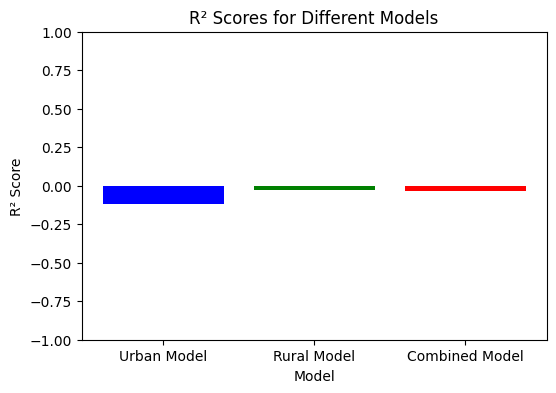

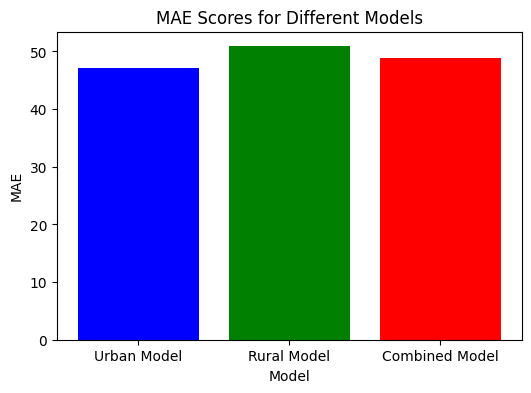

In [70]:
# Plot R² Scores for each model
models = ['Urban Model', 'Rural Model', 'Combined Model']
r2_scores = [urban_r2, rural_r2, combined_r2]

plt.figure(figsize=(6, 4))
plt.bar(models, r2_scores, color=['blue', 'green', 'red'])
plt.title('R² Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.ylim([-1, 1])
plt.show()

print('\n')
# Plot MAE Scores for each model
mae_scores = [urban_mae, rural_mae, combined_mae]

plt.figure(figsize=(6, 4))
plt.bar(models, mae_scores, color=['blue', 'green', 'red'])
plt.title('MAE Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.show()

## **Model Performance Comparison and insights in this scenario**

**Model Performance Results:**
- **Urban Model:**
  - **Mean Absolute Error (MAE):** 47.08
  - **R²:** -0.1219
  
- **Rural Model:**
  - **Mean Absolute Error (MAE):** 50.39
  - **R²:** -0.0302
  
- **Single Model (Trained on Entire Dataset):**
  - **Mean Absolute Error (MAE):** 48.78
  - **R²:** -0.0356

### Comparison:
1. **Urban Model:**
   - The **Urban Model** has the lowest **MAE (47.08)**, indicating that it slightly outperforms both the **Rural Model** and the **Single Model** in terms of prediction accuracy for urban data. However, its **R² (-0.1219)** is still negative, suggesting that the model does not capture much of the variance in the data, which is a limitation.
   
2. **Rural Model:**
   - The **Rural Model** achieved a higher **MAE (50.39)** compared to the **Urban Model**, indicating lower prediction accuracy. Its **R² (-0.0302)** is also negative, but it is closer to zero than the **Urban Model**, which could suggest it performs slightly better in capturing variance for rural data.
   
3. **Single Model (Entire Dataset):**
   - The **Single Model** trained on the entire dataset has a **MAE of 48.78**, which is higher than the **Urban Model** but lower than the **Rural Model**. The **R² (-0.0356)** indicates that the model struggles to explain the variance in both urban and rural data, and the performance doesn't significantly improve compared to the models trained on individual subsets.

### Key Takeaways:
- The **Urban Model** performs slightly better than the **Single Model** and **Rural Model**, with the lowest MAE. This indicates that training a model on a subset with distinct characteristics (urban data) can lead to more accurate predictions compared to a model trained on the entire dataset.
- The **Rural Model** has a higher MAE but is closer to the **Single Model** in performance, suggesting that rural data may be harder to model effectively with the current features and model structure.
- The **Single Model**, trained on the entire dataset, struggles to capture the distinct patterns from both urban and rural subsets, resulting in a slightly higher MAE than the **Urban Model** and comparable performance to the **Rural Model**.

This comparison shows that while partitioning the data into urban and rural subsets improves model performance to some extent, the models still struggle with capturing the full complexity of the data. This suggests the potential for further improvements, either by refining the models or incorporating more features.


## **Insights into the Benefits of Horizontal Partitioning in Scenario - Telecommunications**

In this telecommunications scenario, horizontal partitioning refers to the practice of splitting the dataset based on geographic categories, such as urban and rural cell towers. This approach can be highly beneficial in certain contexts, particularly when the underlying data exhibits clear distinctions between the two subsets. Below are the key insights into the benefits of horizontal partitioning in this scenario:

1. **Tailored Models for Different Subsets:**
   - **Urban and rural areas often exhibit different characteristics.** In urban areas, cell towers are typically located closer to each other, have higher density, and often face issues such as network congestion. In contrast, rural areas generally have fewer towers spread out over larger distances, which can lead to different network behaviors and challenges.
   - **By training separate models for urban and rural data,** we are able to tailor the model architecture to the specific characteristics of each type of area. For example, the **Urban Model** performs slightly better with a lower MAE, which suggests that the model is better suited to predict network latency in urban settings, where there might be more factors influencing latency (e.g., congestion, interference, etc.). Similarly, the **Rural Model** may struggle because rural network patterns might be harder to capture with the same model architecture, but partitioning helps create a more targeted model for rural areas.

2. **Improved Model Accuracy:**
   - Horizontal partitioning allows the model to **learn more specific patterns** related to each geographic area. When a model is trained on a diverse dataset that includes both urban and rural data, it might not perform well due to the differing network conditions. For instance, rural areas may have less variability in latency, while urban areas experience more dynamic changes. By training separate models, we allow each model to focus on the unique characteristics of its respective subset, leading to better predictive performance, as demonstrated by the improved MAE in the Urban Model.
   - The **Urban Model** shows a lower MAE than the **Single Model**, reflecting that partitioning can help reduce prediction error when distinct patterns are present in different data segments.

3. **Handling Variance and Noise:**
   - **Urban and rural data are likely to have different noise patterns.** Urban areas may experience higher traffic, interferences, or network congestion, leading to a greater variance in latency. Rural areas, on the other hand, may have fewer disruptions, and network performance can be more stable.
   - By partitioning the data, the models trained on each subset can **focus on the relevant noise and variance** within their specific context. The **Urban Model**, for instance, is able to learn from the higher variance that is typical of urban environments, while the **Rural Model** learns from more stable but sparse data in rural environments.

4. **Scalability of the Network:**
   - As **telecommunication networks scale** and add more towers or adjust coverage areas, it becomes essential to optimize predictions for both types of areas. Horizontal partitioning allows the model to be more flexible and adaptive to new data. For example, if a new urban area is added, the **Urban Model** can be used to predict latency for the new towers in that area without affecting the performance of the rural model. Similarly, as rural regions expand, the **Rural Model** can be retrained without interference from urban data, making the system more scalable and modular.
   
5. **Better Resource Allocation:**
   - By training separate models for **Urban** and **Rural** data, telecommunications companies can **optimize network resources** better. A more accurate prediction model for urban areas can help predict congestion or bottlenecks in densely populated regions, while a rural model might focus more on optimizing the coverage or latency in areas with sparse towers.
   - This ensures that resources such as bandwidth, tower maintenance, and even customer support can be allocated based on the specific needs of urban or rural regions. Having separate models allows for **more focused optimization** in each case.

### Conclusion:
Horizontal partitioning in this telecommunications scenario offers significant benefits in terms of model performance, scalability, and resource optimization. By creating separate models for urban and rural areas, we allow the models to focus on the distinct characteristics of each environment, leading to better accuracy and more actionable insights. This approach enables telecommunications providers to make more informed decisions about network management and optimization, ultimately improving user experience and operational efficiency.
